Open poweshell in new terminal and run

docker build -t sensing-whale "C:\Users\mayar\OneDrive - Massachusetts Institute of Technology\Desktop\energy-aware"

After building the image, use -v to mount the local DATA directory inside /workspace/data/ in the container:

docker run -it --gpus all --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 -v "C:\Users\mayar\OneDrive - Massachusetts Institute of Technology\Desktop\energy-aware\DATA:/workspace/data" -p 8888:8888 sensing-whale

to detect docker containers run: docker ps

to stop docker container: docker stop 'insert container name'

to delete docker container: docker rm 'insert container name'

## Imported Libraries

In [ ]:
# standard library imports
import logging
import multiprocessing as mp
import os
import random
from collections import defaultdict
from datetime import datetime

# check current working directory and list files
print(os.getcwd())
print(os.listdir())

# numerical & data processing 
import numpy as np
import pandas as pd
import cudf
import cupy as cp
import cuspatial
import cuml  # RAPIDS cuML for accelerated machine learning
import numba

# GPU Status
!nvidia-smi

# geospatial processing 
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely

# Viz 
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, to_hex
import folium
import branca.colormap as cm
import matplotlib.colors as mcolors
import optuna.visualization
import contextily as ctx

# statistical & curve fitting 
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import kstest

# utility 
from kneed import KneeLocator
from tqdm import tqdm  # Import tqdm for the progress bar

print("RAPIDS & required libraries loaded successfully!")


/workspace
['images', 'socdep.eps', 'capture_intervals.pdf', 'logpde.eps', 'quantilecutoff.eps', 'C:\\Users\\mayar\\OneDrive - Massachusetts Institute of Technology\\Desktop\\energy-aware\\CODE\\capture_intervals.eps', 'heatmap_grid.pdf', 'capture_intervals.eps', 'heatmap_grid_shared_colorbar.pdf', 'C:', 'C:\\Users\\mayar\\Desktop\\test_output', 'data', 'C:\\Users\\mayar\\OneDrive - Massachusetts Institute of Technology\\Desktop\\energy-aware\\CODE\\capture_intervals.pdf', 'logpde.pdf', 'thresholds.eps', 'totsoc.pdf', 'totsoc.eps', 'deltacv.eps', 'C:\\Users\\mayar\\OneDrive - Massachusetts Institute of Technology\\Desktop\\energy-aware\\CODE\\capture_intervals.svg', 'socdep.pdf']
Sat Apr 19 23:14:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| G

## Data Cleaning and Preprocessing

Loads and process multi-sheet Excel data

1. **File Loading**: Reads all sheets from `2022_vitals.xlsx` without headers.
2. **Column Naming**: Assigns predefined column names for consistency.
3. **Data Alignment**: 
   - Fixes misaligned rows by detecting valid `deviceID`.
   - Ensures all rows have the correct number of columns.
4. **Filtering**:
   - Removes invalid or duplicate header rows.
   - Drops rows with zero values for latitude (`Lat`) and longitude (`Log`).
5. **Indexing**: Resets the index and assigns a sequential 1-based index.
6. **Output**: Saves the cleaned data to `2022_vitals_cleaned.xlsx` and previews it.

Mount the local data directory to Docker;
docker run -it --gpus all --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 -p 8888:8888 `
    -v "C:\Users\mayar\OneDrive - Massachusetts Institute of Technology\Desktop\energy-aware\DATA:/workspace/data" `
    rapids-custom-container


In [ ]:
import random
import string

# Adjusted file path for Docker (mounted volume)
file_path = "/workspace/data/2022_vitals.xlsx"
output_path = "/workspace/data/2022_vitals_cleaned.xlsx"

# Specify the column names explicitly
column_names = [
    "deviceID", "Timestamp", "Lat", "Log", "SOC_batt", "temp_batt", "volatge_batt",
    "voltage_particle", "current_batt", "isCharging", "isCharginS", "isCharged",
    "Temp_int", "Hum_int", "solar_current", "Cellular_signal_strength", "index"
]

# Load all sheets into a dictionary
sheets_dict = pd.read_excel(file_path, sheet_name=None, header=None)  # No header initially

# Process each sheet
processed_sheets = []
for sheet_name, sheet_data in sheets_dict.items():
    # Ensure the number of columns matches the expected number
    sheet_data = sheet_data.iloc[:, :len(column_names)]

    # Fix misaligned rows where the first column is invalid
    def fix_alignment(row):
        # Convert the row to a list
        row_list = row.tolist()

        # Find the first valid `deviceID` (assumes valid `deviceID` has > 5 characters)
        for i, value in enumerate(row_list):
            if isinstance(value, str) and len(value) > 5:  # Valid `deviceID` found
                aligned_row = row_list[i:i + len(column_names)]
                return aligned_row + [None] * (len(column_names) - len(aligned_row))

        return [None] * len(column_names)

    # Apply alignment fix to all rows
    sheet_data = sheet_data.apply(fix_alignment, axis=1, result_type="expand")

    # Assign column names
    sheet_data.columns = column_names

    # Drop rows where 'deviceID' is still invalid or starts with "deviceID"
    sheet_data = sheet_data[sheet_data['deviceID'].notna()]
    sheet_data = sheet_data[sheet_data['deviceID'] != "deviceID"]

    # Append processed sheet
    processed_sheets.append(sheet_data)

# Concatenate all sheets into one DataFrame
df = pd.concat(processed_sheets, ignore_index=True)

# Drop rows where Lat or Log is 0
df = df[(df['Lat'] != 0) & (df['Log'] != 0)]

# Replace SOC_batt values below 0 with 0
df.loc[df['SOC_batt'] < 0, 'SOC_batt'] = 0

# Correct indexing column to start at 1 and increment sequentially
df.reset_index(drop=True, inplace=True)
df['index'] = df.index + 1

# === Anonymize deviceIDs with random 3-letter uppercase strings ===
unique_ids = df['deviceID'].unique()

def generate_random_name(existing):
    while True:
        name = ''.join(random.choices(string.ascii_uppercase, k=3))
        if name not in existing:
            return name

existing_names = set()
id_map = {}
for original_id in unique_ids:
    short_name = generate_random_name(existing_names)
    id_map[original_id] = short_name
    existing_names.add(short_name)

df['deviceID'] = df['deviceID'].map(id_map)

# Save cleaned data back to Excel
df.to_excel(output_path, index=False)

# Print cleaned data preview
print("Data cleaning completed. Saved to:", output_path)
print(df.head())


Data cleaning completed. Saved to: /workspace/data/2022_vitals_cleaned.xlsx
  deviceID   Timestamp        Lat        Log SOC_batt temp_batt volatge_batt  \
0      NXL  1657558677  59.342079  18.047274       71      21.9         3.95   
1      NXL  1657558707  59.342102  18.047491       71      21.6         3.95   
2      NXL  1657558737  59.342049  18.047604       71      21.6         3.95   
3      NXL  1657558767  59.341831  18.046106       71      21.4         3.95   
4      NXL  1657558797  59.340618  18.041285       71      21.4         3.94   

  voltage_particle current_batt isCharging isCharginS isCharged Temp_int  \
0             3.93          123          0          1         0     22.6   
1             3.93          119          0          1         0     22.6   
2             3.93          117          0          1         0     22.5   
3             3.93          104          0          1         0     22.3   
4             3.93          124          0          1         0

# **Spatiotemporal Binning and Stationary Period Detection**

This enables **spatial binning**, **stationary period detection**, and **temporal filtering** for robust movement analysis.

## **1. Timestamp Conversion**
The Unix timestamp $ T_i $ is converted into a standard datetime format:

$$
T_i^{\text{datetime}} = T_i^{\text{unix}} \times \frac{1}{86400} + \text{epoch}
$$

where:
- $ T_i^{\text{unix}} $ is the raw Unix timestamp in **seconds**,
- $ 86400 $ seconds = **1 day**,
- **Epoch** is the reference starting time (January 1, 1970).

## **2. Ensuring Numeric Latitude and Longitude**
We enforce that latitude ($ \text{Lat} $) and longitude ($ \text{Log} $) are real-valued:

$$
\text{Lat}, \text{Log} \in \mathbb{R}
$$

Non-numeric values are coerced to **NaN**.

## **3. Discretization into a 40m Grid**
### **3.1 Latitude Grid Resolution**
Since the **Earth's meridional circumference** is approximately **40,030 km**, the degree-to-meter conversion near the equator is:

$$
1^\circ \approx 111,320 \text{ meters}
$$

Thus, the spatial resolution of a **40m grid** in latitude is:

$$
\Delta \text{Lat} = \frac{120}{111320}
$$

The **grid-aligned latitude** is computed as:

$$
\text{Lat\_Grid} = \left\lfloor \frac{\text{Lat}}{\Delta \text{Lat}} \right\rfloor \times \Delta \text{Lat}
$$

### **3.2 Longitude Grid Resolution**
Unlike latitude, **longitude spacing** varies with latitude due to Earth’s curvature. The **longitude degree-to-meter conversion** is:

$$
1^\circ \approx 111320 \times \cos(\text{Lat})
$$

Thus, the **longitude resolution** at a given latitude is:

$$
\Delta \text{Log} = \frac{40}{111320 \cos(\text{Lat})}
$$

The **grid-aligned longitude** is computed as:

$$
\text{Log\_Grid} = \left\lfloor \frac{\text{Log}}{\Delta \text{Log}} \right\rfloor \times \Delta \text{Log}
$$

## **4. Sorting by Time and Device**
To track movement **chronologically** for each vehicle, we sort:

$$
\text{Sort}(df, \text{by}=[\text{deviceID}, \text{Timestamp}])
$$

## **5. Identifying Stationary Periods**
For each vehicle, we determine if it remained in the same grid cell over consecutive timestamps:

$$
\text{Same\_Grid}_i =
\begin{cases} 
1, & (\text{Lat\_Grid}_i = \text{Lat\_Grid}_{i-1}) \land (\text{Log\_Grid}_i = \text{Log\_Grid}_{i-1}) \\
0, & \text{otherwise}
\end{cases}
$$

where:
- $ \text{Same\_Grid}_i = 1 $ means no movement occurred.
- $ \text{Same\_Grid}_i = 0 $ means movement occurred.

## **6. Computing Time Spent in a Grid Cell**
The time difference between consecutive records within the same grid is:

$$
\Delta t_i = T_i - T_{i-1}
$$

The **total duration** a vehicle spends within a specific grid cell before moving is:

$$
\text{Cumulative\_Time}_{i} = \sum_{k=1}^{i} \Delta t_k
$$

where:
- The summation continues **until movement occurs**.

## **7. Assigning a Group ID to Each Stationary Period**
A **unique group identifier** is assigned to each stationary period using a cumulative sum:

$$
\text{Group}_i =
\sum_{j=1}^{i} (1 - \text{Same\_Grid}_j)
$$

Each transition into a **new grid cell** increments the group ID.

## **8. Removing Prolonged Stationary Vehicles**
Vehicles remaining in the **same grid for over x hours** (xxx seconds) are excluded:

$$
\text{Remove } i \text{ if } \text{Cumulative\_Time}_i \geq xxx \text{ sec}
$$

## **9. Cleanup**
All intermediate columns used for calculations are dropped to optimize storage.


In [ ]:
# Unix timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# ensure 'Lat' and 'Log' are numeric
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
df['Log'] = pd.to_numeric(df['Log'], errors='coerce')

# spatial resolution
grid_size=40 # 40m grid
lat_resolution = grid_size / 111320 
df['Lat_Grid'] = (df['Lat'] // lat_resolution) * lat_resolution

# Lon resolution depends on Lat
df['Lon_Resolution'] = grid_size / (111320 * np.cos(np.radians(df['Lat'])))
df['Log_Grid'] = (df['Log'] // df['Lon_Resolution']) * df['Lon_Resolution']
df = df.drop(columns=['Lon_Resolution'])

# sort by deviceID and Timestamp
df = df.sort_values(by=['deviceID', 'Timestamp'])

# detect continuous stationary periods
df['Prev_Lat_Grid'] = df.groupby('deviceID')['Lat_Grid'].shift(1)
df['Prev_Log_Grid'] = df.groupby('deviceID')['Log_Grid'].shift(1)
df['Prev_Timestamp'] = df.groupby('deviceID')['Timestamp'].shift(1)

# identify whether the taxi has stayed in the same grid
df['Same_Grid'] = (df['Lat_Grid'] == df['Prev_Lat_Grid']) & (df['Log_Grid'] == df['Prev_Log_Grid'])

# time spent in the grid continuously
df['Time_Diff'] = (df['Timestamp'] - df['Prev_Timestamp']).dt.total_seconds()

# assign group ID that resets when the taxi leaves a grid
df['Group'] = (~df['Same_Grid']).cumsum()

# total time spent in each visit to the grid
df['Cumulative_Time'] = df.groupby(['deviceID', 'Lat_Grid', 'Log_Grid', 'Group'])['Time_Diff'].cumsum()

# ensure 'Cumulative_Time' is not NaN or negative (if any filtering was done previously)
df_filtered = df[df['Cumulative_Time'] > 0]

/tmp/ipykernel_14318/4032612891.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')


✅ Plot saved in working directory: /workspace/capture_intervals.pdf


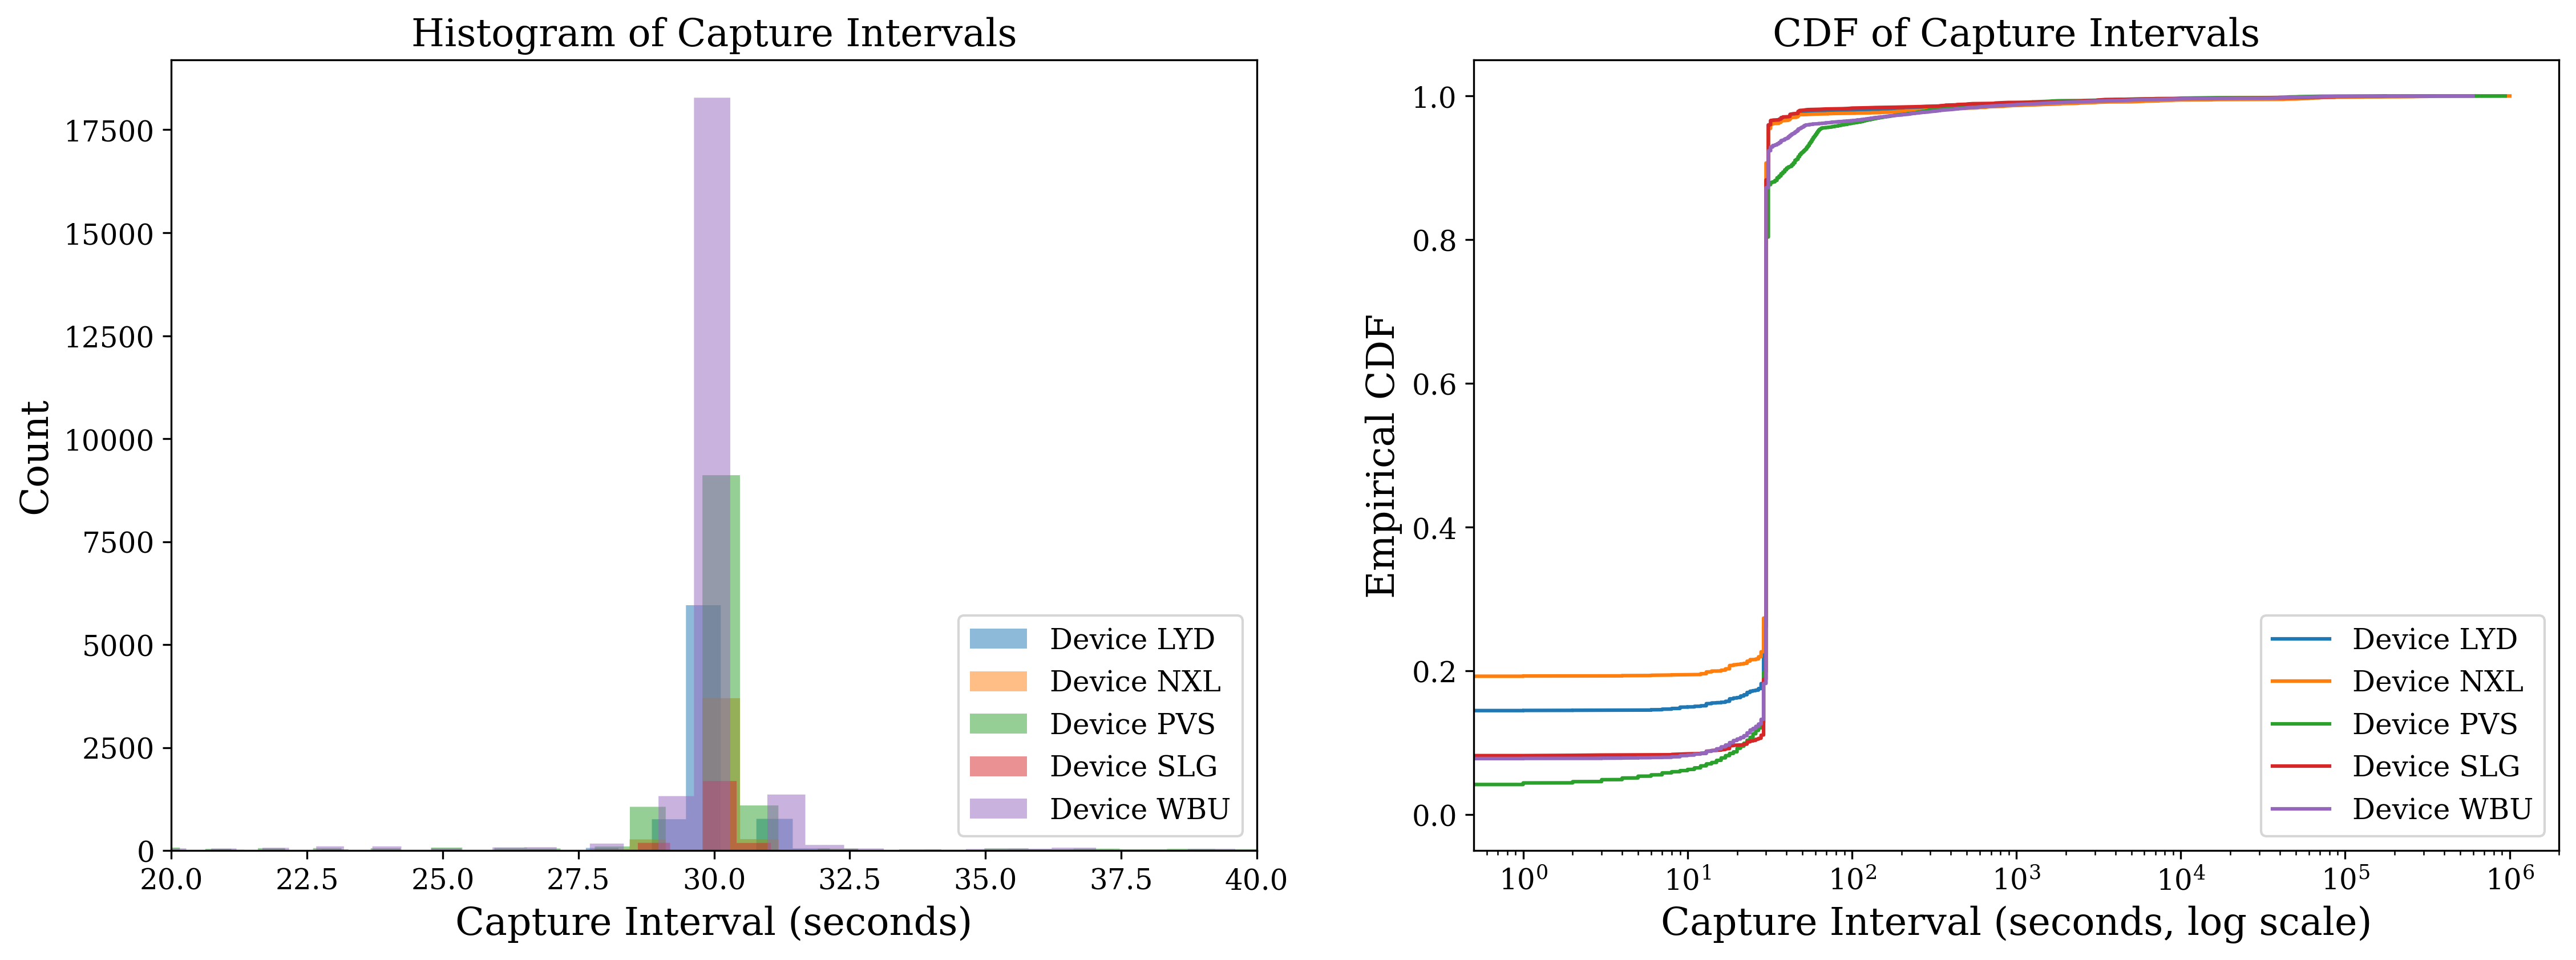

In [ ]:
plt.rcParams.update({
    "text.usetex": False,  # true if LaTeX installed; otherwise keep False and use mathtext
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.family": "serif"
})

fig=plt.figure(figsize=(18, 6), dpi=300)
device_colors =[
    "#1f77b4",  # muted blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
]

# group by device and collect lists of capture intervals (Time_Diff)
intervals_per_device = [
    (device_id, group['Time_Diff'].dropna().values)
    for device_id, group in df_filtered.groupby('deviceID')
]

for i, (device_id, intervals) in enumerate(intervals_per_device):
    sorted_intervals = np.sort(intervals)
    cdf = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # hist with log-spaced bins
    plt.subplot(1, 2, 1)
    min_val = max(np.min(intervals), 1e-1)  # avoid zero or negative
    max_val = np.max(intervals)
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 700)

    plt.hist(intervals, bins=log_bins, alpha=0.5, color=device_colors[i], label=f'Device {device_id}', histtype='stepfilled')
    plt.xscale('linear')
    plt.xlabel('Capture Interval (seconds)')
    plt.ylabel('Count')
    plt.title('Histogram of Capture Intervals')
    plt.grid(False, which='both')
    plt.xlim(20, 40) 
    plt.legend(loc='lower right')

    # CDF 
    plt.subplot(1, 2, 2)
    plt.plot(sorted_intervals, cdf, lw=1.5, color=device_colors[i], label=f'Device {device_id}')
    plt.xscale('log')
    plt.xlabel('Capture Interval (seconds, log scale)')
    plt.ylabel('Empirical CDF')
    plt.title('CDF of Capture Intervals')
    plt.grid(False)
    plt.legend(loc='lower right')

output_path = "capture_intervals.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"✅ Plot saved in working directory: {os.path.abspath(output_path)}")


# **Identifying Optimal Threshold for Cumulative Time in Grids**

## **1. Calculate Empirical Cumulative Distribution Function (ECDF)**
The ECDF is calculated to provide insight into the distribution of cumulative time spent in each grid. The sorted cumulative times and corresponding ECDF values are computed as:

$
\text{sorted\_times} = \text{np.sort}(\text{cumulative\_time\_hours})
$

$
\text{ecdf\_values} = \frac{i}{N}, \quad i = 1, 2, \ldots, N
$

Where $N$ is the total number of data points.

## **2. Optimal Threshold Detection Using Kneedle Algorithm**
The **Kneedle Algorithm** is applied to find the threshold point where the slope of the ECDF curve changes most significantly. This point is considered the optimal threshold that separates short-term and long-term grid occupations.

$
\text{kneedle} = \text{KneeLocator}(\text{sorted\_times}, \text{ecdf\_values}, S=1.0, \text{curve}="concave", \text{direction}="increasing")
$

The detected knee point (optimal threshold) is converted back to seconds:

$
\text{optimal\_threshold\_seconds} = \text{optimal\_threshold\_hours} \times 3600
$


In [ ]:
# Cumulative_Time to hours for easier interpretation
cumulative_time_hours = df_filtered['Cumulative_Time'] / 3600

# ECDF values for analysis
sorted_times = np.sort(cumulative_time_hours)
ecdf_values = np.arange(1, len(sorted_times) + 1) / len(sorted_times)

# optimal threshold using the Kneedle algorithm
kneedle = KneeLocator(sorted_times, ecdf_values, S=1.0, curve="concave", direction="increasing")
optimal_threshold_hours = kneedle.knee
optimal_threshold_seconds = optimal_threshold_hours * 3600

# Hist with Optimal Threshold
plt.figure(figsize=(10, 6))
plt.hist(cumulative_time_hours, bins=100, color='skyblue', label='Cumulative Time Distribution')
plt.axvline(optimal_threshold_hours, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold_hours:.2f} hours')
plt.title('Distribution of Cumulative Time Spent in Each Grid (With Optimal Threshold)')
plt.xlabel('Cumulative Time Spent in Grid (hours)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# ECDF with Optimal Threshold
plt.figure(figsize=(10, 6))
sns.ecdfplot(cumulative_time_hours, label='ECDF of Cumulative Time')
plt.axvline(optimal_threshold_hours, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold_hours:.2f} hours')
plt.title('ECDF of Cumulative Time Spent in Each Grid (With Optimal Threshold)')
plt.xlabel('Cumulative Time Spent in Grid (hours)')
plt.ylabel('Proportion of Data Points')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Threshold Found: {optimal_threshold_hours:.2f} hours ({optimal_threshold_seconds:.0f} seconds)")


In [ ]:
original_entry_count = len(df)

# remove vehicles that stayed continuously in the same grid for more than optimal_threshold_seconds
df = df[~(df['Cumulative_Time'] >= optimal_threshold_seconds)]

removed_entries = original_entry_count - len(df)
df = df.drop(columns=['Prev_Lat_Grid', 'Prev_Log_Grid', 'Prev_Timestamp', 'Same_Grid', 'Time_Diff', 'Group', 'Cumulative_Time'])
print(f"Number of entries removed due to vehicles staying continuously in the same grid for more than {optimal_threshold_hours} hours: {removed_entries}")


## Spatial Grid Aggregation

This script generates a **40m x 40m geospatial grid** and counts the number of data points within each grid cell:

1. **Dynamic Boundary Definition**: 
   - Extracts min/max latitude and longitude from the dataset.
2. **Grid Construction**:
   - Defines **40m resolution** for latitude and dynamically calculates longitude resolution.
   - Iterates over the spatial extent to generate **polygonal grid cells**.
3. **GeoDataFrame Creation**:
   - Converts the grid into a `GeoDataFrame` (`grid_gdf`).
   - Converts data points into a `GeoDataFrame` (`df_gdf`).
4. **Spatial Aggregation**:
   - Checks which points fall within each grid cell.
   - Increments the count of data points within corresponding grid polygons.

In [ ]:
# bounds from the DataFrame
min_lat = df['Lat'].min()
max_lat = df['Lat'].max()
min_lon = df['Log'].min()
max_lon = df['Log'].max()

lon_resolution_at_lat = lambda lat: grid_size / (111320 * np.cos(np.radians(lat)))

# grid of polygons
grid = []
lat = min_lat
while lat < max_lat:
    lon = min_lon
    while lon < max_lon:
        lon_res = lon_resolution_at_lat(lat)
        grid.append(Polygon([
            (lon, lat),
            (lon + lon_res, lat),
            (lon + lon_res, lat + lat_resolution),
            (lon, lat + lat_resolution)
        ]))
        lon += lon_res
    lat += lat_resolution

grid_gdf = gpd.GeoDataFrame({'geometry': grid, 'Count': 0}, crs="EPSG:4326")
# GeoDataFrame for the points in df
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Log'], df['Lat']), crs="EPSG:4326")

# spatial join
joined = gpd.sjoin(df_gdf, grid_gdf, how="left", predicate="within")

# count points per grid cell
grid_gdf['Count'] = joined.groupby(joined.index_right).size()

# NaN with 0 for empty grid cells
grid_gdf['Count'].fillna(0, inplace=True)



# **SOC Depletion Modeling with Sensor OFF Strategies**

## **Context and Objective**
This implementation models the **State of Charge (SOC) depletion** of sensor-equipped vehicles while applying **dynamic sensor OFF strategies** based on pre-defined **time thresholds**. The goal is to assess the impact of temporarily turning **OFF** sensors to conserve energy, tracking **SOC savings**, and evaluating the difference in battery depletion rates under different sensor control policies.

The core of this method involves:
1. **Tracking the energy savings** from sensor OFF periods.
2. **Modeling sensor activation behavior** based on pre-defined **time thresholds**.
3. **Computing the modified SOC depletion** with stored energy savings.
4. **Comparing the baseline SOC depletion with sensor control policies.**

## **1. Data Preparation and Sorting**
The dataset is first copied and indexed sequentially to ensure **chronological order**:

$$
\text{Sort}(df, \text{by}=[\text{Timestamp}])
$$

This sorting is essential for maintaining **temporal consistency**, ensuring that energy tracking occurs in the correct **sequential order**.

## **2. Definition of Sensor OFF Strategy**
A sensor OFF threshold $ T_{\text{threshold}} $ is defined, which determines how long a **grid cell** can remain **inactive** before reactivation is allowed. Given:

$$
T_{\text{threshold}} = \{ 12 \text{ sec} \}
$$

a sensor remains **OFF** if a vehicle has recently occupied the same **grid cell** within the threshold:

$$
\text{Sensor\_ON}_i =
\begin{cases} 
0, & \text{if } (t_i - t_{\text{last sensed}}) < T_{\text{threshold}} \\
1, & \text{otherwise}
\end{cases}
$$

where:
- $ t_i $ is the **current timestamp**.
- $ t_{\text{last sensed}} $ is the timestamp of the **last recorded sensor activation**.
- $ T_{\text{threshold}} $ is the **predefined time limit** for keeping the sensor OFF.

## **3. Energy Storage Mechanism**
During **sensor OFF periods**, the energy that would have been consumed is tracked using a **stored energy accumulation model**. The change in **SOC depletion rate** due to the sensor OFF mechanism is computed as:

$$
\Delta \text{SOC}_i = \max(0, \text{SOC}_{i-1} - \text{SOC}_i)
$$

where:
- $ \text{SOC}_i $ is the **current SOC measurement**.
- $ \text{SOC}_{i-1} $ is the **previous SOC measurement**.

Stored energy savings accumulate over time:

$$
\text{Energy\_Saved}_i = \sum_{j=1}^{i} \Delta \text{SOC}_j, \quad \text{if Sensor\_ON} = 0
$$

where:
- $ \text{Energy\_Saved}_i $ represents the **total accumulated SOC savings**.
- The accumulation occurs **only when the sensor is OFF**.

## **4. Dynamic SOC Update with Energy Savings**
The SOC for a given time step is **recomputed** using the stored energy:

$$
\text{SOC\_batt}_i' = \text{SOC\_batt}_i + \text{Energy\_Saved}_i
$$

where:
- $ \text{SOC\_batt}_i' $ is the **corrected SOC value** incorporating energy savings.
- $ \text{SOC\_batt}_i $ is the **original SOC value**.
- $ \text{Energy\_Saved}_i $ represents the **cumulative stored SOC improvements**.

To ensure **SOC does not exceed 100%**, the final corrected SOC values are clipped:

$$
\text{SOC\_batt}_i' = \min(100, \text{SOC\_batt}_i + \text{Energy\_Saved}_i)
$$

## **5. Baseline and Threshold Comparisons**
To assess the impact of sensor OFF strategies, SOC depletion is **compared across different thresholds**. The average daily SOC depletion per device is computed as:

$$
\text{SOC\_depletion} = \frac{1}{N} \sum_{i=1}^{N} \text{SOC\_batt}_i'
$$

where:
- $ N $ is the number of **time steps in a day**.
- $ \text{SOC\_batt}_i' $ represents the **SOC levels incorporating sensor OFF savings**.

The **baseline depletion rate** without any sensor OFF strategy is also computed:

$$
\text{Baseline\_SOC} = \frac{1}{N} \sum_{i=1}^{N} \text{SOC\_batt}_i
$$

where no energy savings are incorporated.

## **6. Expected Outcomes and Justification**
This method enables:
- **Quantification of energy savings** from sensor OFF strategies.
- **Comparison of SOC depletion trends** across different sensor OFF thresholds.
- **Validation of sensor optimization policies** to maximize battery lifespan.

By implementing **grid-based sensing optimization**, the system **reduces unnecessary sensor activations**, ensuring **longer sensor endurance** while maintaining **effective data collection**.


In [ ]:
df['Date'] = df['Timestamp'].dt.date  
df_temp = df.copy().reset_index(drop=True)  
df_temp=df_temp.sort_values(by=['Timestamp']).reset_index(drop=True) 

# time threshold(s)
time_thresholds = {
    # "3 sec": 3,
    "360 sec": 360
}

# dictionary to store SOC and sensor states for each threshold
soc_depletion_results = {}

# iterate over different time thresholds
for label, TIME_THRESHOLD in time_thresholds.items():

    # track last sensed timestamp, and stored energy during OFF periods
    last_sensed_time = {}
    stored_energy = {}

    prev_date=None
    
    for i in range(len(df_temp)):
        row = df_temp.iloc[i]
        grid_key = (row['Lat_Grid'], row['Log_Grid'])  # unique grid identifier
        current_time = row['Timestamp']
        current_date = row['Date']
        device= row['deviceID']

        # initialise inter-row differences when OFF
        d_diff_prev=0 
        
        # reset stored energy at the start of a new day
        if prev_date is not None and current_date != prev_date:
            stored_energy={}  # reset stored energy for all grid cells
            df_temp.loc[i:, f'Energy_Saved_{label}'] = 0  # reset energy savings for the new day
            print(f"[RESET] Reset stored energy for new day: {current_date}")

        prev_date = current_date  # update previous date tracker

        if df_temp.loc[i, 'SOC_batt']>99:
            stored_energy[grid_key]=0
            df_temp.loc[i:, f'Energy_Saved_{label}']=0

        # if the grid was sensed recently (within the threshold), turn OFF the sensor
        if grid_key in last_sensed_time and (current_time - last_sensed_time[grid_key]).total_seconds() < TIME_THRESHOLD:
            df_temp.at[i, f'Sensor_ON_{label}'] = False   

            # accumulate stored SOC
            if i > 0 and pd.notna(df_temp.iloc[i - 1]['SOC_batt']) and pd.notna(row['SOC_batt']):
            
                # find the last preceding row for this device
                if device == df_temp.iloc[i-1]['deviceID']:
                    d_diff = max(0, df_temp.iloc[i - 1]['SOC_batt'] - row['SOC_batt']) # current inter-row difference
                    diff = max(d_diff_prev, d_diff)
                    stored_energy[grid_key] = df_temp.loc[i-1, f'Energy_Saved_{label}']
                    stored_energy[grid_key] += diff
                    
                    if diff != 0: 
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]
                    else:
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = df_temp.loc[i-1, f'Energy_Saved_{label}']

                    d_diff_prev=diff
                    print(f"[OFF]: Accumulated {diff:.2f}% for device {device}. Total stored: {stored_energy[grid_key]:.2f}%")

                else:
                    d_diff = max(0, df_temp.loc[df_temp.deviceID == device, :]['SOC_batt'].iloc[-1] - row['SOC_batt']) # current inter-row difference
                    diff = max(d_diff_prev, d_diff)
                    stored_energy[grid_key] = df_temp.loc[df_temp.deviceID == device, :][f'Energy_Saved_{label}'].iloc[-1]
                    stored_energy[grid_key] += diff
                    
                    if diff != 0: 
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]
                    else:
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = df_temp.loc[df_temp.deviceID == device, :][f'Energy_Saved_{label}'].iloc[-1]

                    d_diff_prev=diff
                    print(f"CHANGE [OFF]: Accumulated {diff:.2f}% for device {device}. Total stored: {stored_energy[grid_key]:.2f}%")

        else:
            # update last sensed time when the sensor turns ON
            last_sensed_time[grid_key] = current_time
            df_temp.at[i, f'Sensor_ON_{label}'] = True
            d_diff_prev=0

            if device == df_temp.iloc[i-1]['deviceID']:

                # ensure stored_energy is initialized per grid cell without overwriting previous values
                if grid_key not in stored_energy:
                    if i > 0:
                        # carry forward the stored energy from the last known row
                        stored_energy[grid_key] = df_temp.loc[i-1, f'Energy_Saved_{label}']
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]
                    elif i == 0:
                        stored_energy[grid_key] = 0  # First iteration, no prior energy 
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]  
                print(f"[ON]: device {device}. Total stored: {stored_energy[grid_key]:.2f}%")

            else:
                 # ensure stored_energy is initialized per grid cell without overwriting previous values
                if grid_key not in stored_energy:
                    if i > 0:
                        # carry forward the stored energy from the last known row
                        stored_energy[grid_key] = df_temp.loc[df_temp.deviceID == device, :][f'Energy_Saved_{label}'].iloc[-1]
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]
                    elif i == 0:
                        stored_energy[grid_key] = 0  # 1st iteration, no prior energy 
                        df_temp.loc[i:, f'Energy_Saved_{label}'] = stored_energy[grid_key]                 
                
                print(f"CHANGE [ON]: device {device}. Total stored: {stored_energy[grid_key]:.2f}%")

    
    # new SOC_batt with savings
    df_temp[f'SOC_batt_{label}'] = df_temp['SOC_batt'] + df_temp[f'Energy_Saved_{label}']
    df_temp[f'SOC_batt_{label}'] = df_temp[f'SOC_batt_{label}'].clip(upper=100)

    # SOC depletion for this threshold
    daily_soc = df_temp.groupby(['Date', 'deviceID'])[f'SOC_batt_{label}'].mean()
    soc_depletion_results[label] = daily_soc


# BASELINE: SOC depletion without constraints
soc_depletion_results["Baseline"] = df_temp.groupby(['Date', 'deviceID'])['SOC_batt'].mean()

soc_depletion_df = pd.DataFrame(soc_depletion_results)

# save
output_path = "/workspace/data/updated_SOC_batt_with_energy_savings.xlsx"
df_temp.to_excel(output_path, index=False)



In [ ]:
import os

# Define line styles and transparency levels for each threshold
line_styles = {
    "Baseline": "--",
    "360 sec": "-"
}

alpha_values = {
    "Baseline": 0.5,
    "360 sec": 1
}

# Predefined colors for devices
predefined_colors = [
    "#1f77b4",  # muted blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
]

# Build set of all device IDs
device_ids = set()
for soc_series in soc_depletion_results.values():
    device_ids.update(soc_series.index.get_level_values('deviceID').unique())

# Create color map using consistent color order
device_ids = sorted(device_ids)
color_map = {device_id: predefined_colors[i % len(predefined_colors)] for i, device_id in enumerate(device_ids)}

# Begin plot
plt.figure(figsize=(14, 8), dpi=300)

legend_entries = []

# Plot each threshold's data per device
for label, soc_series in soc_depletion_results.items():  # soc_series is MultiIndexed
    for device_id in soc_series.index.get_level_values('deviceID').unique():
        device_data = soc_series[soc_series.index.get_level_values('deviceID') == device_id]
        line, = plt.plot(
            device_data.index.get_level_values('Date'),
            device_data.values,
            linestyle=line_styles[label],
            lw=1.5,
            color=color_map[device_id],
            alpha=alpha_values[label],
            label=f"Device {device_id} - {label}"
        )
        legend_entries.append((f"Device {device_id} - {label}", line))

# Sort legend entries by device color order then by threshold label
device_order = list(color_map.keys())

def extract_key(label):
    parts = label.split(" - ")
    device = parts[0].replace("Device ", "")
    threshold = parts[1] if len(parts) > 1 else ""
    return (device_order.index(device), threshold)

legend_entries = sorted(legend_entries, key=lambda x: extract_key(x[0]))
sorted_labels, sorted_handles = zip(*[(label, handle) for label, handle in legend_entries])

# Apply axis labels and title
plt.xlabel('Date')
plt.ylabel('SOC (%)')
plt.title('SOC Depletion Across Devices')
plt.xticks(rotation=45)
plt.grid(False)

# Plot sorted legend
plt.legend(sorted_handles, sorted_labels, loc='lower right', fontsize=9)

# Final layout and export
plt.tight_layout()
output_path = "socdep.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Plot saved in working directory: {os.path.abspath(output_path)}")

plt.show()


## Baseline vs. Adaptive Gamma Scaling for Grid Analysis

### Baseline Calculation (Without Log Transformation)
1. **Compute Gamma Scaling Parameters:**
   The baseline gamma scaling factor is computed using the mean ($ \mu $) and standard deviation ($ \sigma $) of the counts in each grid cell. The **Coefficient of Variation (CV)** is defined as:

   $
   CV = \frac{\sigma}{\mu}
   $

   The gamma scaling factor is then calculated as:

   $
   \text{baseline\_gamma} = \frac{1}{1 + CV}
   $

2. **Apply Gamma Scaling:**
   To scale the counts, the following transformation is applied:

   $
   \text{Scaled\_Count\_Baseline} = (\text{Count} + 1)^{\text{baseline\_gamma}}
   $

3. **Normalize Counts:**
   The scaled counts are normalized to facilitate visual comparison between different grid cells.

---

### Adaptive Calculation (Sensor-On Data)
1. **Filtering Sensor-On Data:**  
   Only the rows where the sensor is active are considered for the analysis.

2. **Perform Spatial Join:**  
   The filtered data points are spatially joined with the adaptive grid cells to identify which grid cell each point belongs to.

3. **Count Calculation:**  
   The number of points per grid cell is aggregated using:

   $
   \text{Count} = \sum_{i=1}^{N} \text{Point}_i
   $

4. **Apply Gamma Scaling:**  
   Similar to the baseline calculation, the adaptive scaling factor is computed as:

   $
   \text{adaptive\_gamma} = \frac{1}{1 + CV_{\text{adaptive}}}
   $

   The scaled counts are then calculated as:

   $
   \text{Scaled\_Count\_Adaptive} = (\text{Count} + 1)^{\text{adaptive\_gamma}}
   $

5. **Normalize Counts:**  
   The adaptive scaled counts are normalized in a similar fashion to the baseline counts.

---

### Common Scaling for Comparison
1. **Determine Global Minimum and Maximum:**  
   The global minimum and maximum values are computed for both baseline and adaptive scaled counts to ensure consistent scaling.

2. **Sigmoid Scaling for Visualization:**  
   To enhance contrast for visualization, a sigmoid function is applied to the normalized counts:

   $
   \text{Visual} = \frac{1}{1 + \exp\left(-k \left(\text{Normalized\_Scaled} - 0.5\right)\right)}
   $

   Where:
   - $ k $ is a tunable parameter that controls the sharpness of the sigmoid curve.
   - $\text{Normalized\_Scaled}$ represents the normalized count values scaled to a range of [0, 1].

---

### Common $ v_{min} $ Calculation
The common minimum value for visualization is determined by taking the minimum of the baseline and adaptive visual representations.

---

### Common $ v_{max} $ Calculation (Using Kneedle Algorithm)
1. **Quantile Range Creation:**  
   A range of quantile values ($ q $) from 0.90 to 1.0 is generated to capture the upper tail of the distribution.

2. **CV Difference Calculation:**  
   The coefficient of variation ($CV$) is calculated at each quantile cutoff for both baseline and adaptive visualizations. The difference between the two is then recorded as:

   $
   \text{CV Difference} = \left| \text{CV}_{\text{Baseline}} - \text{CV}_{\text{Adaptive}} \right|
   $

3. **Filtering and Kneedle Detection:**  
   Initial flat portions of the curve are removed using a threshold filter to eliminate insignificant changes.  
   The **Kneedle Algorithm** is applied to detect the optimal quantile where the difference in CVs is most pronounced.

4. **Determine Common $ v_{max} $:**  
   The common maximum value is determined by taking the minimum of the baseline and adaptive quantiles at the optimal quantile level:

   $
   v_{\text{max}} = \min\left( \text{Baseline Quantile}, \text{Adaptive Quantile} \right)
   $

---

### Visualization and Results Display
The calculated values of $ v_{\text{min}} $ and $ v_{\text{max}} $ are applied for consistent and enhanced visualization of both baseline and adaptive counts. The optimal quantile provides a well-calibrated view of the difference between baseline and adaptive approaches.


In [ ]:
grid_gdf_baseline = grid_gdf.copy()
grid_gdf_adaptive = grid_gdf.copy()

### BASELINE
# Gamma Scaling on Raw Counts (Without Log Transformation)
baseline_counts = df_temp.groupby(['Lat_Grid', 'Log_Grid']).size()
mean_count_baseline = grid_gdf_baseline['Count'].mean()
std_count_baseline = grid_gdf_baseline['Count'].std()
CV_baseline = std_count_baseline / mean_count_baseline if mean_count_baseline > 0 else 1
baseline_gamma = 1 / (1 + CV_baseline)

# gamma scaling directly on raw counts
grid_gdf_baseline['Scaled_Count_Baseline'] = (grid_gdf_baseline['Count'] + 1) ** baseline_gamma

# Normalize the Scaled Counts for Better Visual Comparison
scaled_min_baseline = grid_gdf_baseline['Scaled_Count_Baseline'].min()
scaled_max_baseline = grid_gdf_baseline['Scaled_Count_Baseline'].max()

### ADAPTIVE
# label used in code
label = "360 sec"

# Filter the dataset to include only rows where the sensor is ON
adaptive_df = df_temp[df_temp[f'Sensor_ON_{label}'] == True]

# GeoDataFrame for the points in df
adaptive_df_gdf = gpd.GeoDataFrame(adaptive_df, geometry=gpd.points_from_xy(adaptive_df['Log'], adaptive_df['Lat']), crs="EPSG:4326")

# Perform spatial join for Adaptive case
joined = gpd.sjoin(adaptive_df_gdf, grid_gdf_adaptive, how="left", predicate="within")
grid_gdf_adaptive['Count'] = joined.groupby(joined.index_right).size()
grid_gdf_adaptive['Count'].fillna(0, inplace=True)

# Gamma Scaling on Raw Counts (Without Log Transformation)
adaptive_counts = adaptive_df.groupby(['Lat_Grid', 'Log_Grid']).size()
mean_count_adaptive = grid_gdf_adaptive['Count'].mean()
std_count_adaptive = grid_gdf_adaptive['Count'].std()
CV_adaptive = std_count_adaptive / mean_count_adaptive if mean_count_adaptive > 0 else 1
adaptive_gamma = 1 / (1 + CV_adaptive)

# gamma scaling directly on raw counts
grid_gdf_adaptive['Scaled_Count_Adaptive'] = (grid_gdf_adaptive['Count'] + 1) ** adaptive_gamma

# Normalize the Scaled Counts for Better Visual Comparison
scaled_min_adaptive = grid_gdf_adaptive['Scaled_Count_Adaptive'].min()
scaled_max_adaptive = grid_gdf_adaptive['Scaled_Count_Adaptive'].max()

# Global min and max for both datasets
global_min = min(scaled_min_baseline, scaled_min_adaptive)
global_max = max(scaled_max_baseline, scaled_max_adaptive)
print(f"Global Min: {global_min}, Global Max: {global_max}")

# Sigmoid Scaling ONLY for Viz (Baseline)
grid_gdf_baseline['Normalized_Scaled_Baseline'] = (grid_gdf_baseline['Scaled_Count_Baseline'] - global_min) / (global_max - global_min)
k = 10  # Adjust this value for better contrast enhancement
grid_gdf_baseline['Visual_Baseline'] = 1 / (1 + np.exp(-k * (grid_gdf_baseline['Normalized_Scaled_Baseline'] - 0.5)))

# Sigmoid Scaling ONLY for Viz (Adaptive)
grid_gdf_adaptive['Normalized_Scaled_Adaptive'] = (grid_gdf_adaptive['Scaled_Count_Adaptive'] - global_min) / (global_max - global_min)
grid_gdf_adaptive['Visual_Adaptive'] = 1 / (1 + np.exp(-k * (grid_gdf_adaptive['Normalized_Scaled_Adaptive'] - 0.5)))


### COMMON VMIN
# common vmin for both Baseline and Adaptive visualizations
common_vmin = min(
    grid_gdf_baseline['Visual_Baseline'].min(),
    grid_gdf_adaptive['Visual_Adaptive'].min()
)

print(f"Computed common_vmin: {common_vmin:.4f}")

### COMMON VMAX 

# quantile range
quantile_range = np.linspace(0.90, 1, 1000)
cv_differences = []

for q in quantile_range:
    baseline_q = grid_gdf_baseline['Visual_Baseline'].quantile(q)
    adaptive_q = grid_gdf_adaptive['Visual_Adaptive'].quantile(q)
    
    cv_baseline = np.std(grid_gdf_baseline['Visual_Baseline'][grid_gdf_baseline['Visual_Baseline'] <= baseline_q]) / np.mean(grid_gdf_baseline['Visual_Baseline'][grid_gdf_baseline['Visual_Baseline'] <= baseline_q])
    cv_adaptive = np.std(grid_gdf_adaptive['Visual_Adaptive'][grid_gdf_adaptive['Visual_Adaptive'] <= adaptive_q]) / np.mean(grid_gdf_adaptive['Visual_Adaptive'][grid_gdf_adaptive['Visual_Adaptive'] <= adaptive_q])
    
    cv_differences.append(abs(cv_baseline - cv_adaptive))

# Filter out the initial flat part by thresholding
threshold_value = 0.01  # Adjust this value if needed
filtered_indices = np.where(np.array(cv_differences) > threshold_value)[0]

# Apply Kneedle only if there's a significant increase
if len(filtered_indices) > 0:
    filtered_quantiles = quantile_range[filtered_indices]
    filtered_cv_differences = np.array(cv_differences)[filtered_indices]

    # kneed to find the optimal quantile
    kneedle = KneeLocator(filtered_quantiles, filtered_cv_differences, curve='convex', direction='increasing')
    optimal_quantile = round(kneedle.elbow, 3)  # Display to three decimals
else:
    # Fallback if no significant increase is detected
    optimal_quantile = 0.990  # A sensible high quantile to use

# improvement trend
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(quantile_range, cv_differences, color='blue', label='CV Difference')
plt.axvline(optimal_quantile, color='red', linestyle='--', label=f'Optimal Quantile = {optimal_quantile:.3f}')
plt.title('CV Difference vs Quantile Cutoff')
plt.xlabel('Quantile Cutoff')
plt.ylabel('CV Difference')
plt.legend()
plt.grid(False)

print(f"Optimal Quantile Found: {optimal_quantile:.3f}")


common_vmax = min(
    grid_gdf_baseline['Visual_Baseline'].quantile(optimal_quantile),
    grid_gdf_adaptive['Visual_Adaptive'].quantile(optimal_quantile)
)

print(f"Computed common_vmin: {common_vmax:.4f}")

output_path = "quantilecutoff.eps"
plt.savefig(output_path, format='eps', bbox_inches='tight')
print(f"Plot saved in working directory: {os.path.abspath(output_path)}")

plt.show()


In [ ]:
print(f"Baseline Optimal Gamma: {baseline_gamma:.4f}")

colormap = cm.LinearColormap(
    colors=['darkblue', 'cyan', 'yellow', 'orangered'],
    vmin=common_vmin,
    vmax=common_vmax
)

m = folium.Map(location=[df['Lat'].mean(), df['Log'].mean()], zoom_start=12, tiles='Cartodb positron')

# GeoJSON overlay
geojson = folium.GeoJson(
    grid_gdf_baseline,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Visual_Baseline']),
        'weight': 0.0,
        'fillOpacity': 0.4
    }
).add_to(m)

colormap.caption = "Scaled Count Intensity (Baseline)"
colormap.add_to(m) 

m

## Baseline vs. Adaptive Sensing Statistics and Improvement Calculation

### Baseline Statistics Calculation
The baseline statistics are calculated based on all the measurements collected within grid cells. 

1. **Count Calculation:**
   The total number of measurements per grid cell is calculated using:

   $
   \text{Baseline Counts} = \sum_{i=1}^{N} \text{Point}_i
   $

   Where $ N $ is the total number of measurements per grid cell.

2. **Statistical Metrics:**
   - Mean count ($ \mu_{\text{baseline}} $):

    $
    \mu_{\text{baseline}} = \frac{1}{M} \sum_{j=1}^{M} C_j
    $

    Where $ M $ is the number of grid cells, and $ C_j $ is the count of measurements in cell $ j $.

   - Standard deviation ($ \sigma_{\text{baseline}} $):

    $
    \sigma_{\text{baseline}} = \sqrt{\frac{1}{M} \sum_{j=1}^{M} (C_j - \mu_{\text{baseline}})^2}
    $

   - Coefficient of Variation ($ CV_{\text{baseline}} $):

    $
    CV_{\text{baseline}} = \frac{\sigma_{\text{baseline}}}{\mu_{\text{baseline}}}
    $

---

### Adaptive Sensing Statistics Calculation
The adaptive statistics are calculated based on the filtered measurements where the sensor is **ON**.

1. **Count Calculation:**
   Similar to the baseline calculation, but only considering the filtered dataset:

   $
   \text{Adaptive Counts} = \sum_{i=1}^{N'} \text{Point}_i
   $

   Where $ N' \leq N $ represents the subset of measurements where the sensor is active.

2. **Statistical Metrics:**

   - Mean count ($ \mu_{\text{adaptive}} $):

    $
    \mu_{\text{adaptive}} = \frac{1}{M'} \sum_{j=1}^{M'} C_j
    $

   - Standard deviation ($ \sigma_{\text{adaptive}} $):

    $
    \sigma_{\text{adaptive}} = \sqrt{\frac{1}{M'} \sum_{j=1}^{M'} (C_j - \mu_{\text{adaptive}})^2}
    $

   - Coefficient of Variation ($ CV_{\text{adaptive}} $):

    $
    CV_{\text{adaptive}} = \frac{\sigma_{\text{adaptive}}}{\mu_{\text{adaptive}}}
    $

---

### Improvement in Spatial Uniformity
The improvement in spatial uniformity between the baseline and adaptive sensing techniques is quantified using the change in the Coefficient of Variation:

1. **Change in Coefficient of Variation ($ \Delta CV $):**

   $
   \Delta CV = CV_{\text{baseline}} - CV_{\text{adaptive}}
   $

2. **Percentage Improvement in Uniformity:**

   $
   \text{Percentage Improvement} = \left( \frac{\Delta CV}{CV_{\text{baseline}}} \right) \times 100
   $

---

### Visualization of Measurement Distribution
The distributions of counts per grid cell for both baseline and adaptive sensing methods are plotted using histograms.

- The histograms are compared side-by-side to illustrate differences in measurement uniformity.
- The title, labels, and legend provide context for understanding the comparison.


In [ ]:
# baseline statistics
baseline_counts = df_temp.groupby(['Lat_Grid', 'Log_Grid']).size()
mean_count_baseline = baseline_counts.mean()
std_count_baseline = baseline_counts.std()
cv_baseline = std_count_baseline / mean_count_baseline

print(f"Baseline Statistics:")
print(f"Mean Count: {mean_count_baseline:.4f}")
print(f"Standard Deviation: {std_count_baseline:.4f}")
print(f"CV (Baseline): {cv_baseline:.4f}")

# Filter the dataset to include only rows where the sensor is ON
adaptive_df = df_temp[df_temp[f'Sensor_ON_{label}'] == True]

# adaptive statistics
adaptive_counts = adaptive_df.groupby(['Lat_Grid', 'Log_Grid']).size()
mean_count_adaptive = adaptive_counts.mean()
std_count_adaptive = adaptive_counts.std()
cv_adaptive = std_count_adaptive / mean_count_adaptive

print(f"\n Adaptive Sensing Statistics ({label}):")
print(f"Mean Count: {mean_count_adaptive:.4f}")
print(f"Standard Deviation: {std_count_adaptive:.4f}")
print(f"CV (Adaptive): {cv_adaptive:.4f}")

# improvement in uniformity
delta_cv = cv_baseline - cv_adaptive
percentage_improvement = (delta_cv / cv_baseline) * 100

print(f"\n Improvement in Spatial Uniformity (ΔCV): {delta_cv:.4f}")
print(f" Percentage Improvement in Uniformity: {percentage_improvement:.2f}%")

# histogram of counts for baseline and adaptive scenarios
plt.figure(figsize=(12, 6))

plt.hist(baseline_counts, bins=50, alpha=0.5, label='Baseline (All Measurements)')
plt.hist(adaptive_counts, bins=50, alpha=0.5, label=f'Adaptive Sensing ({label})')

plt.title('Distribution of Measurements per Grid Cell')
plt.xlabel('Number of Measurements per Grid Cell')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Adaptive Optimal Gamma: {adaptive_gamma:.4f}")

colormap = cm.LinearColormap(
    colors=['darkblue', 'cyan', 'yellow', 'orangered'],
    vmin=common_vmin,
    vmax=common_vmax
)

m = folium.Map(location=[df['Lat'].mean(), df['Log'].mean()], zoom_start=12, tiles='Cartodb positron')

# GeoJSON overlay for the adaptive map
geojson = folium.GeoJson(
    grid_gdf_adaptive,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Visual_Adaptive']),
        'weight': 0.0,
        'fillOpacity': 0.4
    }
).add_to(m)

colormap.caption = "Count Intensity (Adaptive)"
colormap.add_to(m)

m

## Enhanced Difference Calculation for Visual Maps

### Normalization of Visual Maps
To allow for a consistent comparison between **Baseline** and **Adaptive** maps, both visual maps are normalized between $0$ and $1$ using min-max normalization:

$
\text{Normalized\_Visual\_Baseline} = \frac{\text{Visual\_Baseline} - \text{visual\_baseline\_min}}{\text{visual\_baseline\_max} - \text{visual\_baseline\_min}}
$

$
\text{Normalized\_Visual\_Adaptive} = \frac{\text{Visual\_Adaptive} - \text{visual\_adaptive\_min}}{\text{visual\_adaptive\_max} - \text{visual\_adaptive\_min}}
$

Where:
- $ \text{visual\_baseline\_min}, \text{visual\_baseline\_max} $ are the minimum and maximum values of the baseline visualization.
- $ \text{visual\_adaptive\_min}, \text{visual\_adaptive\_max} $ are the minimum and maximum values of the adaptive visualization.

---

### Enhanced Difference Calculation
The relative improvement is calculated by comparing the **Adaptive Visualization** against the **Baseline Visualization**. 

1. **Difference Calculation:**
   $
   \text{Difference} = \text{Normalized\_Visual\_Adaptive} - \text{Normalized\_Visual\_Baseline}
   $

2. **Difference Sign Identification:**
   The sign of the difference is identified to distinguish between positive and negative improvements.

   $
   \text{Difference\_Sign} = \text{sign}(\text{Difference})
   $

---

### Sigmoid Scaling for Enhanced Visualization
To enhance the contrast of the differences, a **sigmoid function** is applied. This mapping provides a more sensitive representation of differences, particularly useful for visual comparison.

$
\text{Enhanced\_Difference} = \text{Difference\_Sign} \times \left( \frac{1}{1 + \exp(-k \cdot \text{Difference})} - 0.5 \right)
$

Where:
- $ k $ is a tuning parameter controlling the steepness of the sigmoid function.  
- Higher $ k $ values result in stronger contrast, highlighting even small differences.

---

### Normalization of Enhanced Differences
The enhanced differences are normalized to a range of $ [0, 1] $ for visual mapping:

$
\text{Enhanced\_Difference\_Vis} = \frac{\text{Enhanced\_Difference} - \text{enhanced\_diff\_min}}{\text{enhanced\_diff\_max} - \text{enhanced\_diff\_min}}
$

Where:
- $ \text{enhanced\_diff\_min} $ and $ \text{enhanced\_diff\_max} $ are the minimum and maximum values of $ \text{Enhanced\_Difference} $.

---

### Colormap Definition
To highlight the improvements, a **Blue-White Colormap** is defined, where:

- **White (0):** Represents no improvement.  
- **Blue (1):** Represents maximum improvement.

---

### Folium Map Generation
A **Folium Map** is generated to visualize the improvements:

1. **GeoJSON Overlay:**  
   The difference map is added as a GeoJSON overlay with custom styling based on the normalized enhanced differences.

2. **Colormap:**  
   A colormap legend is added to the map to indicate the intensity of improvement.

In [ ]:
# Ensure Both Visual Maps Are Normalized Between 0 and 1
visual_baseline_min = grid_gdf_baseline['Visual_Baseline'].min()
visual_baseline_max = grid_gdf_baseline['Visual_Baseline'].max()
grid_gdf_baseline['Normalized_Visual_Baseline'] = (grid_gdf_baseline['Visual_Baseline'] - visual_baseline_min) / (visual_baseline_max - visual_baseline_min)

visual_adaptive_min = grid_gdf_adaptive['Visual_Adaptive'].min()
visual_adaptive_max = grid_gdf_adaptive['Visual_Adaptive'].max()
grid_gdf_adaptive['Normalized_Visual_Adaptive'] = (grid_gdf_adaptive['Visual_Adaptive'] - visual_adaptive_min) / (visual_adaptive_max - visual_adaptive_min)

# Relative Improvement (Enhanced Difference Calculation)
grid_gdf_adaptive['Difference'] = grid_gdf_adaptive['Normalized_Visual_Adaptive'] - grid_gdf_baseline['Normalized_Visual_Baseline']
grid_gdf_adaptive['Difference_Sign'] = np.sign(grid_gdf_adaptive['Difference'])

# Sigmoid Scaling (Adjust k for more/less aggressive enhancement)
# k = 30  # Increase for stronger contrast, decrease for smoother visualization
grid_gdf_adaptive['Enhanced_Difference'] = grid_gdf_adaptive['Difference_Sign'] * (1 / (1 + np.exp(-k * grid_gdf_adaptive['Difference'])) - 0.5)

# Normalization of Enhanced Differences for Optimal Visualization
enhanced_diff_min = grid_gdf_adaptive['Enhanced_Difference'].min()
enhanced_diff_max = grid_gdf_adaptive['Enhanced_Difference'].max()

# Normalizing to range [0, 1] for Blue intensities
grid_gdf_adaptive['Enhanced_Difference_Vis'] = (grid_gdf_adaptive['Enhanced_Difference'] - enhanced_diff_min) / (enhanced_diff_max - enhanced_diff_min)


In [ ]:
colormap = cm.LinearColormap(
    colors=['white','blue'], 
    vmin=0,  # Minimum of normalized data
    vmax=1   # Maximum of normalized data
)

m = folium.Map(location=[df['Lat'].mean(), df['Log'].mean()], zoom_start=12, tiles='Cartodb positron')

# GeoJSON overlay for difference map
geojson = folium.GeoJson(
    grid_gdf_adaptive,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Enhanced_Difference_Vis']),
        'weight': 0.0,
        'fillOpacity': 0.4
    }
).add_to(m)

colormap.caption = "Improvement Map (Uniformity Improvement in Blue)"
colormap.add_to(m)

m

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, levene

# Statistical Tests
t_stat, t_pvalue = ttest_ind(baseline_counts, adaptive_counts, equal_var=False)
u_stat, mw_pvalue = mannwhitneyu(baseline_counts, adaptive_counts, alternative='two-sided')
ks_stat, ks_pvalue = ks_2samp(baseline_counts, adaptive_counts)
levene_stat, levene_pvalue = levene(baseline_counts, adaptive_counts)

# Improvement metrics
delta_cv = cv_baseline - cv_adaptive
percentage_improvement = (delta_cv / cv_baseline) * 100

# Store results in a comparative DataFrame
results_df = pd.DataFrame({
    'Metric': ['Mean Count (μ)', 'Standard Deviation (σ)', 'Coefficient of Variation (CV)', 
               'Improvement in Uniformity (ΔCV)', 'Percentage Improvement in Uniformity', 
               'T-Test (p-value)', 'Mann-Whitney U (p-value)', 'Kolmogorov-Smirnov (p-value)', 'Levene Test (p-value)'],
    'Baseline': [mean_count_baseline, std_count_baseline, cv_baseline, delta_cv, percentage_improvement,
                 t_pvalue, mw_pvalue, ks_pvalue, levene_pvalue],
    'Adaptive': [mean_count_adaptive, std_count_adaptive, cv_adaptive, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
})

print(results_df)

# Log Transformation to make extreme values more visible
baseline_counts_log = np.log1p(baseline_counts)  # Log transform baseline counts
adaptive_counts_log = np.log1p(adaptive_counts)  # Log transform adaptive counts

# PDFs for Baseline vs. Adaptive (Log scale) with 50% transparent fills
plt.figure(figsize=(10, 8), dpi=300)   
sns.kdeplot(baseline_counts_log, label='Baseline', color="#d62728", fill=True, alpha=0.3)
sns.kdeplot(adaptive_counts_log, label='Adaptive', color="#2ca02c", fill=True, alpha=0.3)
plt.title('Log Transformed Probability Density Functions')
plt.xlabel('Log(Number of Measurements per Grid Cell)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.xlim(0.5, 2)
plt.grid(False)

output_path = "logpde.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Plot saved in working directory: {os.path.abspath(output_path)}")
plt.show()


In [ ]:
# Energy Efficiency Analysis
if 'SOC_batt' in df_temp.columns and 'SOC_batt_360 sec' in df_temp.columns:
    # Calculate total SOC for baseline and adaptive approaches (sum of SOC values)
    total_soc_baseline = df_temp['SOC_batt'].sum()
    total_soc_adaptive = df_temp['SOC_batt_360 sec'].sum()

    # energy savings as the difference in total SOC
    energy_savings = total_soc_adaptive - total_soc_baseline
    percentage_energy_savings = (energy_savings / total_soc_baseline) * 100

    # DataFrame for energy efficiency analysis
    energy_efficiency_df = pd.DataFrame({
        'Metric': ['Total SOC (Baseline)', 'Total SOC (Adaptive)', 
                   'Energy Savings (Absolute)', 'Percentage Energy Savings'],
        'Value': [total_soc_baseline, total_soc_adaptive, energy_savings, percentage_energy_savings]
    })
    
    # total SOC comparison with restricted x-axis range
    plt.figure(figsize=(10, 8), dpi=300)
    sns.kdeplot(df_temp['SOC_batt'], label='Baseline', color="#d62728", fill=True, alpha=0.3)
    sns.kdeplot(df_temp['SOC_batt_360 sec'], label='Adaptive', color="#2ca02c", fill=True, alpha=0.3)
    plt.title('Total SOC Comparison')
    plt.xlabel('SOC [%]')
    plt.ylabel('Density')
    plt.xlim(0, 100)  # Crop the x-axis to the valid range of SOC values
    plt.legend(loc='upper right')
    plt.grid(False)
    output_path = "totsoc.pdf"
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"Plot saved in working directory: {os.path.abspath(output_path)}")
    plt.show()

    print(energy_efficiency_df)


In [ ]:
# Temporal Analysis of CV Over Time (Every 5 Minutes, Displayed Every 30 Minutes)
df_temp['Hour'] = pd.to_datetime(df_temp['Timestamp']).dt.strftime('%H:%M')

# Convert to datetime format and round to nearest 5-minute interval
df_temp['Hour'] = pd.to_datetime(df_temp['Hour']).dt.floor('15T').dt.strftime('%H:%M')

# Group by 5-minute intervals and calculate CV for baseline and adaptive approaches
hourly_stats = df_temp.groupby('Hour').agg({
    'SOC_batt': ['mean', 'std'],
    'SOC_batt_360 sec': ['mean', 'std']
})

# CV for each 5-minute interval
hourly_stats['CV_Baseline'] = hourly_stats[('SOC_batt', 'std')] / hourly_stats[('SOC_batt', 'mean')]
hourly_stats['CV_Adaptive'] = hourly_stats[('SOC_batt_360 sec', 'std')] / hourly_stats[('SOC_batt_360 sec', 'mean')]

# Extract available range from the data
available_times = pd.to_datetime(hourly_stats.index)
start_time = available_times.min()
end_time = available_times.max()

# Generate x-ticks for every half-hour within the available range
x_ticks = pd.date_range(start=start_time, end=end_time, freq='60T').strftime('%H:%M')

# Temporal Changes in CV
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(hourly_stats.index, hourly_stats['CV_Baseline'], label='Baseline', marker='o', color="#d62728")
plt.plot(hourly_stats.index, hourly_stats['CV_Adaptive'], label='Adaptive', marker='o', color="#2ca02c")
plt.title('Temporal Changes in Coefficient of Variation')
plt.xlabel('Time of the Day')
plt.ylabel('Coefficient of Variation')
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper right')
output_path = "deltacv.eps"
plt.savefig(output_path, format='eps', bbox_inches='tight')
print(f"Plot saved in working directory: {os.path.abspath(output_path)}")
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from joblib import Parallel, delayed

# Ensure required columns
if 'Lat_Grid' not in grid_gdf_adaptive.columns or 'Log_Grid' not in grid_gdf_adaptive.columns:
    grid_gdf_adaptive['Lat_Grid'] = adaptive_df['Lat_Grid']
    grid_gdf_adaptive['Log_Grid'] = adaptive_df['Log_Grid']

# Calculate 'Difference' if missing
if 'Difference' not in grid_gdf_adaptive.columns:
    grid_gdf_adaptive['Difference'] = grid_gdf_adaptive['Normalized_Visual_Adaptive'] - grid_gdf_baseline['Normalized_Visual_Baseline']

# Prepare spatial data
filtered_data = grid_gdf_adaptive
spatial_data = filtered_data[['Lat_Grid', 'Log_Grid', 'Difference']].dropna()
X = spatial_data[['Lat_Grid', 'Log_Grid']].values

# Function to evaluate a single k
def evaluate_k(k, X):
    try:
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        k_distances = np.sort(distances[:, k-1])
        kneedle = KneeLocator(np.arange(len(k_distances)), k_distances, curve='convex', direction='increasing')
        knee_idx = kneedle.knee
        knee_distance = k_distances[knee_idx] if knee_idx is not None else np.nan
        return k, knee_distance, k_distances
    except:
        return k, np.nan, None

# Parallel analysis over k_values
def analyze_k_distance_parallel(X, k_values=range(5, 300, 5), n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_k)(k, X) for k in k_values
    )

    optimal_distances = {k: d for k, d, _ in results}
    k_distances_dict = {k: dist for k, _, dist in results if dist is not None}

    k_list = list(optimal_distances.keys())
    distance_list = list(optimal_distances.values())
    distances_array = np.array([d if d is not np.nan else 0 for d in distance_list])
    
    # slopes (first derivative)
    slopes = np.diff(distances_array)
    
    # sharpest jump (best_k)
    best_k_index = np.argmax(slopes)
    best_k = k_list[best_k_index]
    best_k_distance = optimal_distances[best_k]

    # `k_min`: Start of gradual increase before the sharp rise
    window_size = 3  # Number of consecutive increasing slopes to detect
    for i in range(best_k_index - 1, -1, -1):
        if np.all(slopes[i - window_size + 1: i + 1] > 0):
            k_min = k_list[i]
            break
    else:
        k_min = k_list[0]

    # `k_max` (when the slope stabilizes)
    normalized_slopes = slopes / np.max(slopes)
    stabilization_indices = np.where(normalized_slopes < 0.05)[0]

    if len(stabilization_indices) > 0:
        k_max = k_list[stabilization_indices[0] + best_k_index]
    else:
        k_max = k_list[-1]
    
    # best k-distance curve
    if best_k in k_distances_dict:
        best_k_distances = k_distances_dict[best_k]
        plt.figure(figsize=(10, 5), dpi=300)
        plt.plot(best_k_distances, label=f'{best_k}-distance curve')
        knee_idx = np.where(best_k_distances == best_k_distance)[0][0] if not np.isnan(best_k_distance) else None
        if knee_idx is not None:
            plt.axvline(knee_idx, color='red', linestyle='--', label=f'Knee at index: {knee_idx}')
            plt.axhline(best_k_distance, color='green', linestyle='--', label=f'Distance: {best_k_distance:.4f}')
        plt.title(f'Best k-Distance Plot (k={best_k})')
        plt.xlabel("Sorted Points")
        plt.ylabel(f"Distance to {best_k}th Nearest Neighbor")
        plt.legend()
        plt.grid(True)
        plt.show()

    # evolution of thresholds and slopes on dual axes
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=300)

    # distance thresholds
    color1 = "#1f77b4"
    ax1.set_xlabel("$k$ Number of Nearest Neighbors")
    ax1.set_ylabel("$d$ Distance Threshold", color=color1)
    ax1.plot(k_list, distance_list, marker='.', color=color1, label='$d$')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.axvline(k_min, color="#ff7f0e", linestyle='--', label=f'$k_{{\\min}}$: {k_min}')
    ax1.axvline(best_k, color="#2ca02c", linestyle='--', label=f'$k_{{\\mathrm{{best}}}}$: {best_k}')
    ax1.axvline(k_max, color="#9467bd", linestyle='--', label=f'$k_{{\\max}}$: {k_max}')

    # second y-axis for slope
    ax2 = ax1.twinx()
    color2 = "#d62728"
    ax2.set_ylabel(r"($\Delta d / \Delta k$) Rate of Change", color=color2)
    ax2.plot(k_list[:-1], slopes, marker='x', color=color2, label=r'$\Delta d / \Delta k$')
    ax2.tick_params(axis='y', labelcolor=color2)

    # legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc='center right',  bbox_to_anchor=(0.9, 0.5), frameon=True)

    plt.title("Evolution of Distance Threshold and its Gradient vs $k$")
    plt.grid(False)
    output_path = "thresholds.eps"
    plt.savefig(output_path, format='eps', bbox_inches='tight')
    print(f"Plot saved in working directory: {os.path.abspath(output_path)}")
    plt.show()


    return optimal_distances, k_min, best_k, k_max

# Run Analysis with a Full Range of k-values
optimal_distances, k_min, k_best, k_max = analyze_k_distance_parallel(X)

# Generate Suggested Parameter Ranges Automatically
n_points = X.shape[0]
suggested_min_samples = list(range(k_min, k_max + 1, 5))  # Range of min_samples

print(f"\nTotal Number of Points: {n_points}")
print("\nAuto-estimated min_samples range:", suggested_min_samples)

In [ ]:
from sklearn.model_selection import ParameterSampler
from hdbscan import validity_index
import hdbscan
from branca.colormap import LinearColormap
from tqdm import tqdm
from joblib import Parallel, delayed
import random
import warnings
from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

# Optional: set seed
# SEED = 42
percentage = 1  # Set percentage of total values for search
# random.seed(SEED)

# hyperparameter search space
param_dist = {
    'min_samples': np.arange(k_min, k_max + 1, 1),            
    'min_cluster_size': np.arange(k_max, 235 + 1, 5),     
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# valid combinations where min_samples <= min_cluster_size
param_samples = [
    {
        'min_samples': ms,
        'min_cluster_size': mcs,
        'cluster_selection_method': method,
        'metric': metric
    }
    for ms, mcs, method, metric in product(
        param_dist['min_samples'],
        param_dist['min_cluster_size'],
        param_dist['cluster_selection_method'],
        param_dist['metric']
    )
    if ms <= mcs
]

k = round(len(param_samples) * percentage)
param_samples = random.sample(param_samples, k)

# Define function to run HDBSCAN on one parameter set
def evaluate_hdbscan(params):
    try:
        model = hdbscan.HDBSCAN(
            min_samples=params['min_samples'],
            min_cluster_size=params['min_cluster_size'],
            cluster_selection_method=params['cluster_selection_method'],
            metric=params['metric'],
            gen_min_span_tree=True
        )
        model.fit(X)
        if len(np.unique(model.labels_)) > 1:
            score = validity_index(X, model.labels_)
        else:
            score = np.nan
        return {
            'DBCV': score,
            'min_samples': params['min_samples'],
            'min_cluster_size': params['min_cluster_size'],
            'metric': params['metric'],
            'method': params['cluster_selection_method'],
            'labels': model.labels_
        }
    except Exception:
        return {
            'DBCV': np.nan,
            'min_samples': params['min_samples'],
            'min_cluster_size': params['min_cluster_size'],
            'metric': params['metric'],
            'method': params['cluster_selection_method'],
            'labels': np.full(X.shape[0], -1)
        }

# search in parallel
parallel_results = Parallel(n_jobs=-1, backend="loky")(
    delayed(evaluate_hdbscan)(params) for params in tqdm(param_samples, desc="Parallel HDBSCAN Search", leave=True)
)

results_df = pd.DataFrame(parallel_results)

# best parameters
best_row = results_df.loc[results_df['DBCV'].idxmax()]
best_score = best_row['DBCV']
best_params = best_row[['min_samples', 'min_cluster_size', 'metric', 'method']].to_dict()
best_labels = best_row['labels']

print(f"Best Parameters: {best_params}")
print(f"Best DBCV score: {best_score}")

# best clustering
spatial_data = spatial_data.copy()
spatial_data['HDBSCAN_Cluster_Label'] = best_labels

combinations = [
    ('eom', 'manhattan'),
    ('eom', 'euclidean'),
    ('leaf', 'manhattan'),
    ('leaf', 'euclidean')
]

# global DBCV range
vmin = results_df['DBCV'].min()
vmax = results_df['DBCV'].max()

fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)

for ax, (method, metric) in zip(axes.flat, combinations):
    filtered = results_df[
        (results_df['method'] == method) & (results_df['metric'] == metric)
    ]
    if filtered.empty:
        ax.set_visible(False)
        continue

    heatmap_data = filtered.pivot(
        index='min_cluster_size',
        columns='min_samples',
        values='DBCV'
    )

    if heatmap_data.empty:
        ax.set_visible(False)
        continue

    sns.heatmap(
        heatmap_data,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        cbar=False  
    )
    ax.set_title(f"{method.upper()} + {metric.capitalize()}", fontsize=14)
    ax.set_xlabel("min_samples")
    ax.set_ylabel("min_cluster_size")

cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.5])  
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Dummy array for colorbar
fig.colorbar(sm, cax=cbar_ax, label="DBCV Score")

plt.suptitle("HDBSCAN DBCV Scores Across Hyperparameter Combinations", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Reserve space for the colorbar

output_path = "heatmap_grid_shared_colorbar.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"✅ Grid with shared colorbar saved at: {os.path.abspath(output_path)}")

plt.show()



In [ ]:
unique_labels = np.unique(best_labels)
num_unique_labels = len(unique_labels)
colormap = plt.get_cmap('hsv', num_unique_labels)
colors = {label: colormap(i / num_unique_labels) for i, label in enumerate(unique_labels)}
colors_hex = {
    label: f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
    for label, (r, g, b, _) in colors.items()
}

map_clusters = folium.Map(
    location=[spatial_data['Lat_Grid'].mean(), spatial_data['Log_Grid'].mean()],
    zoom_start=13, tiles='Cartodb dark_matter'
)

# Add points
for _, row in spatial_data.iterrows():
    label = row['HDBSCAN_Cluster_Label']
    color = 'white' if label == -1 else colors_hex.get(label, 'gray')
    folium.CircleMarker(
        location=[row['Lat_Grid'], row['Log_Grid']],
        radius=1,
        color=color,
        weight=0,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(map_clusters)

cluster_colormap = LinearColormap(
    colors=[colors_hex[label] for label in unique_labels if label != -1],
    vmin=min(unique_labels),
    vmax=max(unique_labels),
    caption="Cluster Labels"
)
cluster_colormap.add_to(map_clusters)

map_clusters